In [2]:
import copy
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


from superprimitive_fusion.scanner import (
    virtual_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    generate_rgbd_noise_moge_like,
    clean_mesh_and_remap_weights,
    virtual_mesh_scan,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)

In [3]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {filename.split('.')[0]}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

Getting the mustard-bottle
Getting the table
Getting the power-drill


In [4]:
centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

In [52]:
cam_centre=obj_centre + polar2cartesian(0.6, 60, 90)
look_at=obj_centre
width_px: int = 360
height_px: int = 240
fov: float = 70.0
k: float = 5
max_normal_angle_deg = None

In [112]:
meshlist = gt_mesh_list
width_px:               int=360
height_px:              int=240
fov:                    float=70
constant_perlin_sigma:  float=2e-4  # constant perlin noise term
linear_perlin_sigma:    float=3e-3  # linear depth term
quadrt_perlin_sigma:    float=1e-3  # quadratic depth term
perlin_octaves:         int=3
seg_scale_std:          float=1e-4  # std of per-segment scale noise
rot_std:                float=1e-4  # std of global rotation noise
trn_std:                float=1e-3  # std of global translation noise
sigma_floor:            float=0     # prevents infinite weights
grazing_lambda:         float=1.0   # sigma multiplier at grazing angles; 0 disables
seed = None
include_depth_image:    bool=False

cam_centre_np = np.asarray(cam_centre) if isinstance(cam_centre, tuple) else cam_centre
look_at_np = np.asarray(look_at) if isinstance(look_at, tuple) else look_at
up = [0, 0, 1]

scan_result = virtual_scan(
    meshlist,
    cam_centre_np,
    look_at_np,
    width_px=width_px,
    height_px=height_px,
    fov=fov,
    up=up,
)

look_dir = look_at_np - cam_centre_np
look_dir = look_dir / (np.linalg.norm(look_dir) + 1e-12)

verts_noised, weights = generate_rgbd_noise(
    verts_img=scan_result['verts'],
    cam_centre=cam_centre,
    look_dir=look_dir,
    normals_img=scan_result['norms'],
    segmt_img=scan_result['segmt'],
    
    con_perlin=constant_perlin_sigma,
    lin_perlin=linear_perlin_sigma,
    qdr_perlin=quadrt_perlin_sigma,
    oct_perlin=perlin_octaves,
    seg_scale_std=seg_scale_std,
    rot_std=rot_std,
    trn_std=trn_std,
    grazing_lambda=grazing_lambda,
    sigma_floor=sigma_floor,
    seed=seed,
)

L = look_dir / np.linalg.norm(look_dir)
depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)

object_meshes, object_weights = mesh_depth_image(
    points=verts_noised,
    weights=weights,
    vertex_colours=scan_result['vcols'],
    look_dir=look_dir,
    cam_centre=cam_centre_np,
    z=depth,
    segmentation=scan_result['segmt'],
    normals=scan_result['norms'],
    k=k,
    max_normal_angle_deg=max_normal_angle_deg,
)

VN_flat = verts_noised.reshape(-1, 3).astype(np.float64, copy=False)
valid_VN = np.isfinite(VN_flat).all(axis=1)
valid_verts_noised = VN_flat[valid_VN]

V_flat = scan_result['verts'].reshape(-1, 3).astype(np.float64, copy=False)
valid_V = np.isfinite(V_flat).all(axis=1)
valid_verts = V_flat[valid_V]

pcd1 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(valid_verts))
pcd1.paint_uniform_color(np.array([1, 0, 0]))
pcd2 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(valid_verts_noised))
pcd2.paint_uniform_color(np.array([0, 1, 0]))

o3d.visualization.draw_geometries([pcd1, pcd2])

/var/folders/bs/3nkwh0fn3dlgwt0xc5n0pnrc0000gn/T/ipykernel_35142/2486481854.py:54: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [94]:
for mesh in object_meshes:
    mesh.compute_vertex_normals()
o3d.visualization.draw_geometries(object_meshes)

In [ ]:

# mesh_list, trimmed_weights_list = mesh_depth_image(
#     points=verts_noised,
#     weights=weights,
#     vertex_colours=scan_result['vcols'],
#     look_dir=look_dir,
#     cam_centre=cam_centre,
#     segmentation=scan_result['segmt'],
#     normals=scan_result['norms'],
#     k=3.5,
#     max_normal_angle_deg=max_normal_angle_deg,
# )

# clean_mesh_list, clean_weights_list = [], []
# for mesh,weights in zip(mesh_list, trimmed_weights_list):
#     m, w = clean_mesh_and_remap_weights(mesh, weights)
#     clean_mesh_list.append(m)
#     clean_weights_list.append(w)

# mesh_weight_list.append(tuple((m,w) for m,w in zip(clean_mesh_list, clean_weights_list)))

In [6]:
ml0 = [mesh for mesh,weight in mesh_weight_list[0]]
print(ml0)

colours = distinct_colours(len(ml0))

# Suppose your meshes are in a list called `meshes`
coloured_meshes = []
for i,mesh in enumerate(ml0):
    m = copy.deepcopy(mesh)
    m.paint_uniform_color(colours[i])
    coloured_meshes.append(m)

o3d.visualization.draw_geometries(coloured_meshes)

[TriangleMesh with 3903 points and 7552 triangles., TriangleMesh with 34687 points and 68282 triangles., TriangleMesh with 3523 points and 6710 triangles.]


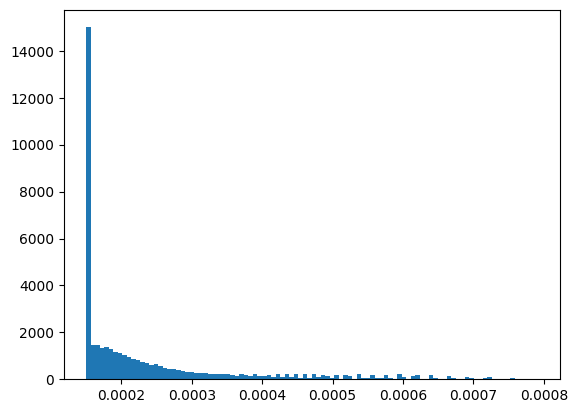

In [6]:
# _ = plt.hist((1/np.sqrt(weights[weights!=0])).reshape(-1),bins=100)
w0 = np.concatenate([w for m,w in mesh_weight_list[0]])
_ = plt.hist((1/np.sqrt(w0)).reshape(-1),bins=100)

In [7]:
shading = distinct_colours(len(mesh_weight_list[0]), s=0.5, v=0.99)

pcd_list = []
for i,mesh_weight in enumerate(mesh_weight_list[0]):
    mesh, weight = mesh_weight
    pcd = o3d.geometry.PointCloud(mesh.vertices)
    nrm_wts = weight / weight.max()
    colours_np = np.concatenate([
        nrm_wts[:,None]             *shading[i,0],
        1-nrm_wts[:,None]           *shading[i,1],
        np.ones((len(nrm_wts),1))   *shading[i,2]], axis=1)
    pcd.colors = o3d.utility.Vector3dVector(colours_np)
    pcd_list.append(pcd)
o3d.visualization.draw_geometries(pcd_list)

In [ ]:
m0, w0 = mesh_weight_list[0][0]
m1, w1 = mesh_weight_list[1][0]

fused_mesh, fused_weight = fuse_meshes(
    mesh1           = m0,
    weights1        = w0,
    mesh2           = m1,
    weights2        = w1,
    h_alpha         = 2.5,
    r_alpha         = 2.0,
    nrm_shift_iters = 2,
    nrm_smth_iters  = 1,
    shift_all       = False,
    fill_holes      = False,
)

In [13]:
print(len(mesh_weight_list[0]))

3


In [22]:
o3d.visualization.draw_geometries([fused_mesh])

In [ ]:
N = len(mesh_weight_list[0]) # Number of objects in the scene
assert len(mesh_weight_list[0]) == len(mesh_weight_list[1]) # Scans should have the same number of objects

fused_mesh_weights = []
for obj_id in range(N):
    
    fused_mesh, fused_weight = fuse_meshes(
        mesh1           = mesh_weight_list[0][obj_id][0],
        weights1        = mesh_weight_list[0][obj_id][1],
        mesh2           = mesh_weight_list[1][obj_id][0],
        weights2        = mesh_weight_list[1][obj_id][1],
        h_alpha         = 2.5,
        r_alpha         = 2.0,
        nrm_shift_iters = 2,
        nrm_smth_iters  = 1,
        shift_all       = False,
        fill_holes      = False,
    )
    
    fused_mesh_weights.append((fused_mesh, fused_weight))

[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.


In [23]:
fused_meshes = [mw[0] for mw in fused_mesh_weights]
o3d.visualization.draw_geometries(fused_meshes)